#  Прогнозирование заказов такси

**Задача:** Предсказать кол-во заказов на следующий час

**Данные:** Заказы такси за 6 месяцев с интервалом в 10 минут.
Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Метрика:** `RMSE` должна получиться не больше 48



## Подготовка

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv',parse_dates=['datetime'])

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
df['datetime'].describe(datetime_is_numeric=True)

count                  26496
mean     2018-05-31 23:55:00
min      2018-03-01 00:00:00
25%      2018-04-15 23:57:30
50%      2018-05-31 23:55:00
75%      2018-07-16 23:52:30
max      2018-08-31 23:50:00
Name: datetime, dtype: object

In [6]:
df['datetime'].is_monotonic_increasing

True

In [7]:
df['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

<AxesSubplot:>

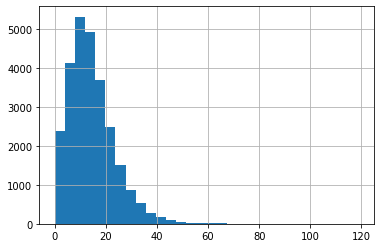

In [8]:
df['num_orders'].hist(bins=30)

In [9]:
df = df.set_index('datetime')

In [10]:
df = df.resample('1H').sum()

In [11]:
df.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [12]:
df.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

## Анализ

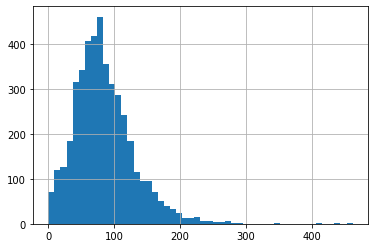

In [13]:
df['num_orders'].hist(bins=50)
plt.show()

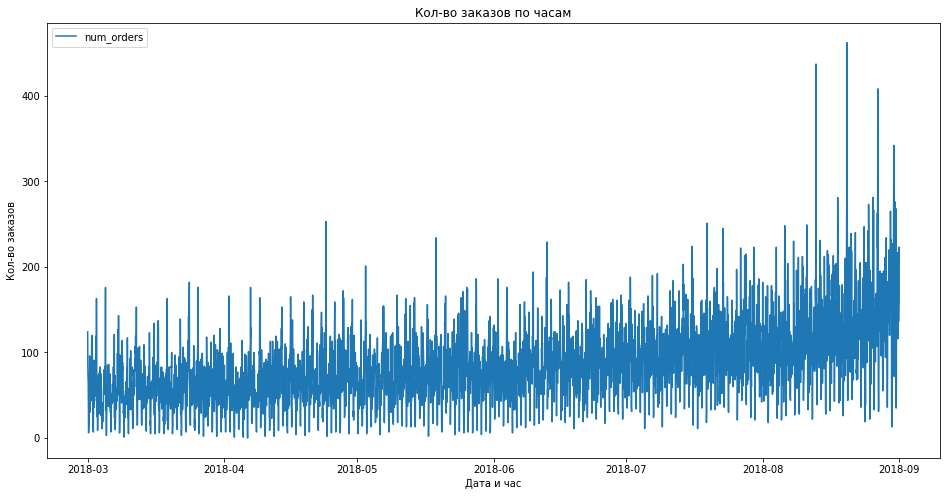

In [14]:
# df.plot()
plt.figure(figsize=(16,8))
plt.title('Кол-во заказов по часам')
sns.lineplot(data=df)
plt.xlabel('Дата и час')
plt.ylabel('Кол-во заказов')
plt.show()

Это не стационарный временной ряд. Т.к. увеличивается среднее и разброс.

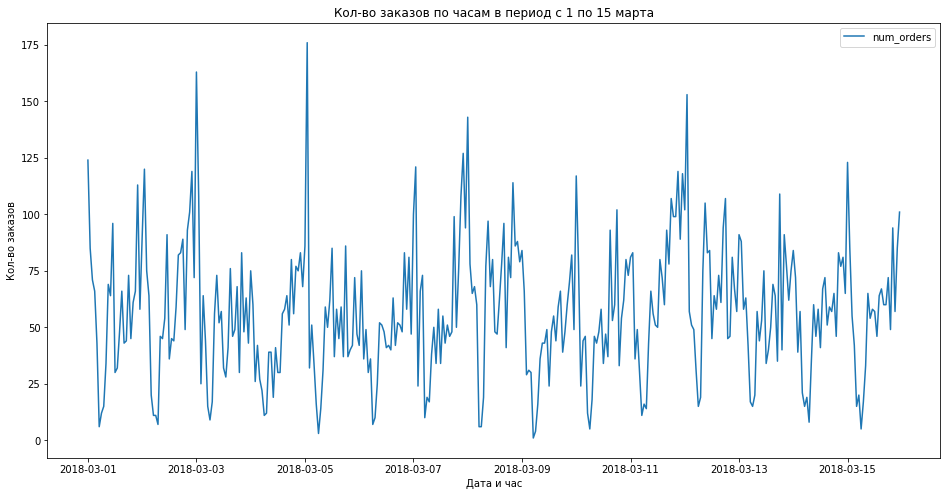

In [15]:
# df.plot()
plt.figure(figsize=(16,8))
sns.lineplot(data=df['2018-03-01':'2018-03-15'])
plt.title('Кол-во заказов по часам в период с 1 по 15 марта')
plt.xlabel('Дата и час')
plt.ylabel('Кол-во заказов')
plt.show()

Видна цикличность.

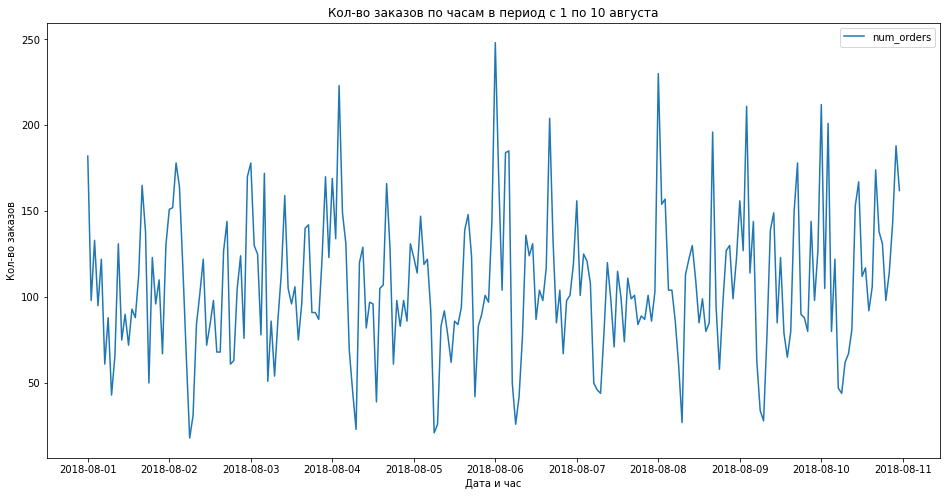

In [16]:
# df.plot()
plt.figure(figsize=(16,8))
sns.lineplot(data=df['2018-08-01':'2018-08-10'])
plt.title('Кол-во заказов по часам в период с 1 по 10 августа')
plt.xlabel('Дата и час')
plt.ylabel('Кол-во заказов')
plt.show()

Увеличилось среднее кол-во и волатильность.

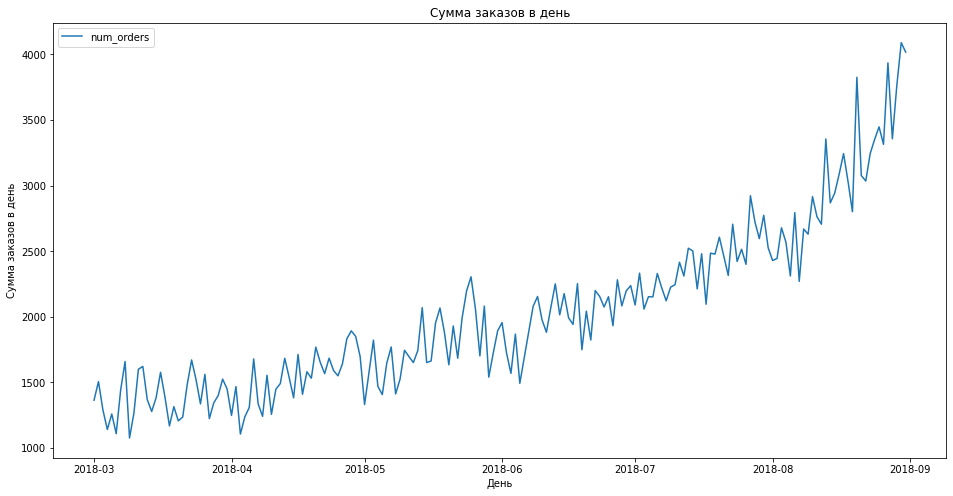

In [17]:
plt.figure(figsize=(16,8))
sns.lineplot(data=df.resample('1D').sum())
plt.title('Сумма заказов в день')
plt.xlabel('День')
plt.ylabel('Сумма заказов в день')
plt.show()

Кол-во заказов в день растет.

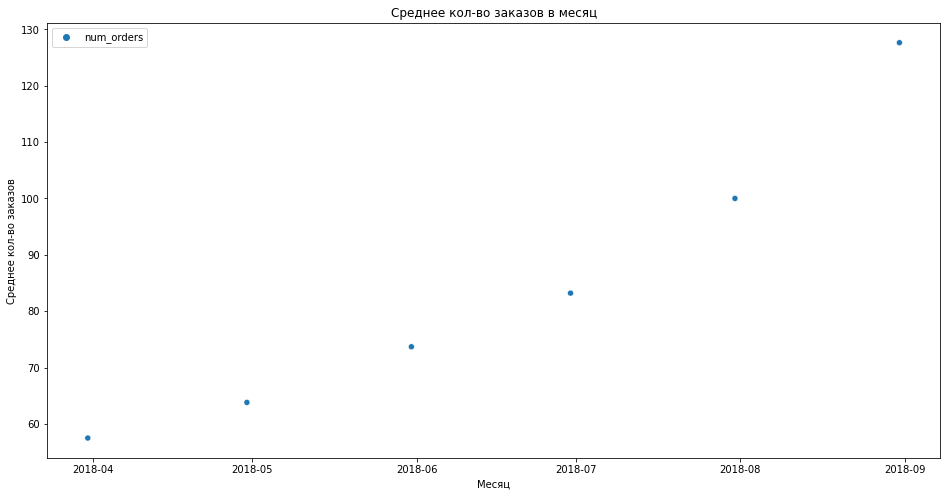

In [18]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=df.resample('1M').mean())
plt.title('Среднее кол-во заказов в месяц')
plt.xlabel('Месяц')
plt.ylabel('Среднее кол-во заказов')
plt.show()

Из месяца в месяц тоже.

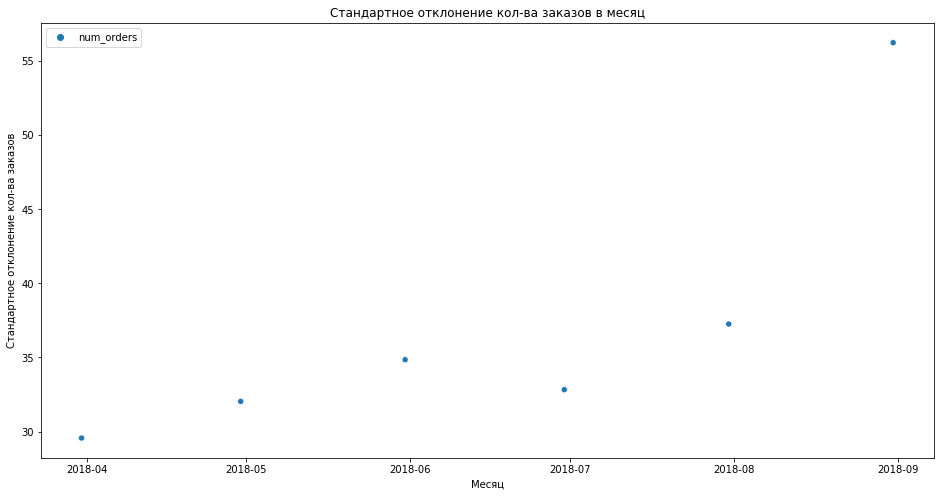

In [19]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=df.resample('1M').std())
plt.title('Стандартное отклонение кол-ва заказов в месяц')
plt.xlabel('Месяц')
plt.ylabel('Стандартное отклонение кол-ва заказов')
plt.show()

Меняется и стандартное отклонение с каждым месяцем.

Декомпозируем.

In [20]:
s_decompose = seasonal_decompose(df)


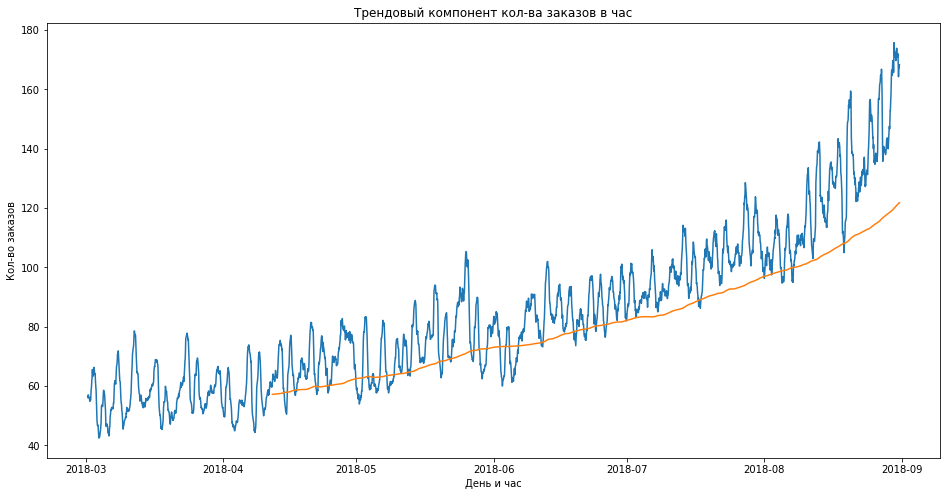

In [21]:
plt.figure(figsize=(16,8))
sns.lineplot(data=s_decompose.trend,)
sns.lineplot(data=s_decompose.trend.rolling(1000).mean())
plt.title('Трендовый компонент кол-ва заказов в час')
plt.xlabel('День и час')
plt.ylabel('Кол-во заказов')
plt.show()




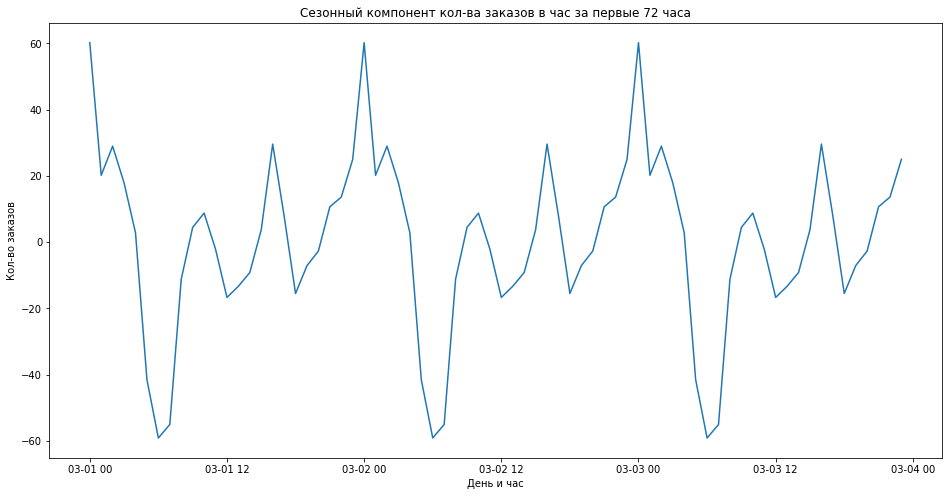

In [22]:
plt.figure(figsize=(16,8))
# sns.lineplot(data=s_decompose.trend)
sns.lineplot(data=s_decompose.seasonal[:72])
# sns.lineplot(data=s_decompose.resid)
plt.title('Сезонный компонент кол-ва заказов в час за первые 72 часа')
plt.xlabel('День и час')
plt.ylabel('Кол-во заказов')
plt.show()




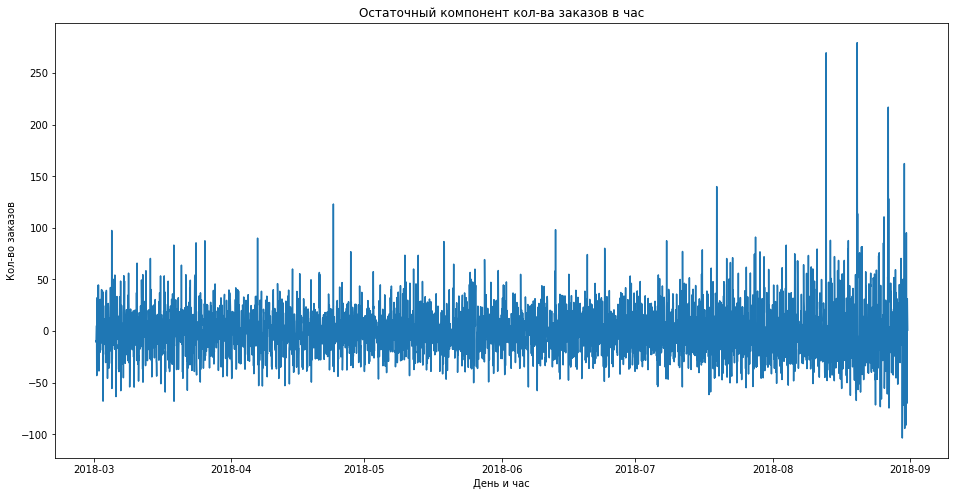

In [23]:
plt.figure(figsize=(16,8))
# sns.lineplot(data=s_decompose.trend)
# sns.lineplot(data=s_decompose.seasonal)
sns.lineplot(data=s_decompose.resid)
plt.title('Остаточный компонент кол-ва заказов в час')
plt.xlabel('День и час')
plt.ylabel('Кол-во заказов')
plt.show()




## Обучение

Создадим фичи. Будем использовать лаг, чтобы уловить "сезонный" компонент и скользящее среднее, чтобы уловить трендовый компонент.

In [24]:
def make_features(df, max_lag, rolling_mean_size):

    data = df.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

#     data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

df_ = make_features(df, 100, 100)
df_.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_ = df_.dropna()

In [26]:
train,test = train_test_split(df_,shuffle=False,test_size=0.1)
# train = train.dropna()
X_train,y_train = train.drop(columns='num_orders'),train['num_orders']
X_test,y_test = test.drop(columns='num_orders'),test['num_orders']

In [27]:
# linreg = LinearRegression().fit(X_train,y_train)
# pred_train = linreg.predict(X_train)
# pred_test = linreg.predict(X_test)

# print("RMSE обучающей выборки:", mean_squared_error(pred_train,y_train,squared=False))
# print("RMSE тестовой выборки: ", mean_squared_error(pred_test,y_test,squared=False))

Сделаем `TimeSeriesSplit`

In [28]:
test_size = round(df_.shape[0] * 0.1)
ts_split = TimeSeriesSplit(n_splits=7,max_train_size=None,test_size=test_size)
print(ts_split)

# for train_idx,test_idx in ts_split.split(df_):
#     display(df_.iloc[train_idx].shape)
#     display(min(train_idx))
#     display(max(train_idx))
#     display(df_.iloc[test_idx].shape)
#     display(min(test_idx))
#     display(max(test_idx))

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=432)


Проверим линейную регрессию на кросс валидации.

In [29]:
linreg = LinearRegression()
# X,y = train.drop(columns='num_orders'),train['num_orders']
linreg_cv = cross_val_score(linreg,X_train,y_train,cv=ts_split,scoring='neg_root_mean_squared_error')
print(linreg_cv)

[-22.20047969 -20.13380124 -23.45167158 -21.8417658  -24.14805694
 -27.13894536 -30.01217027]


In [30]:
linreg_cv.mean(),linreg_cv.std()

(-24.132412984612525, 3.140581450539382)

Подберем гиперпараметры для случайного леса.

In [31]:
forest = RandomForestRegressor()

params = {'n_estimators':[10,100,500],
          'max_depth':[2,4],
#           'max_features':[5,20,50],
         }


forest_gs = GridSearchCV(forest,params,cv=ts_split,scoring='neg_root_mean_squared_error')
forest_gs.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=432),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4], 'n_estimators': [10, 100, 500]},
             scoring='neg_root_mean_squared_error')

In [32]:
best_forest_cv = pd.DataFrame(forest_gs.cv_results_).loc[5,['split0_test_score',
                                                           'split1_test_score',
                                                           'split2_test_score',
                                                           'split3_test_score',
                                                           'split4_test_score',
                                                           'split5_test_score',
                                                           'split6_test_score']].values

In [33]:
pd.DataFrame(forest_gs.cv_results_).loc[5,['mean_test_score','std_test_score']]

mean_test_score   -25.985845
std_test_score      4.644203
Name: 5, dtype: object

Сравним результативность моделей на сплитах.

In [34]:
pd.DataFrame([linreg_cv,best_forest_cv],index=['linreg','forest'])

,0,1,2,3,4,5,6
linreg,-22.200480,-20.133801,-23.451672,-21.841766,-24.148057,-27.138945,-30.012170
forest,-23.073686,-21.974921,-24.513660,-23.018902,-24.372372,-28.688548,-36.258828


In [35]:
pd.DataFrame([[linreg_cv.mean(),linreg_cv.std()],[best_forest_cv.mean(),best_forest_cv.std()]],
             index=['linreg','forest'],
             columns=['mean','std'])

,mean,std
linreg,-24.132413,3.140581
forest,-25.985845,4.644203


Результаты очень похожи. Возможно, дополнительную точность можно получить с помощью дополнительного feature engineering.  
Плюс лес не способен давать предсказания за пределами диапазона трейна, поэтому выбираем линейную регрессию.

In [36]:
linreg.fit(X_train,y_train)

LinearRegression()

In [37]:
linreg_prediction = linreg.predict(X_test)

In [38]:
result = y_test.to_frame()
result['prediction'] = linreg_prediction


In [39]:
print("RMSE тестовой выборки: ", mean_squared_error(linreg_prediction,y_test,squared=False))

RMSE тестовой выборки:  40.12172459187781


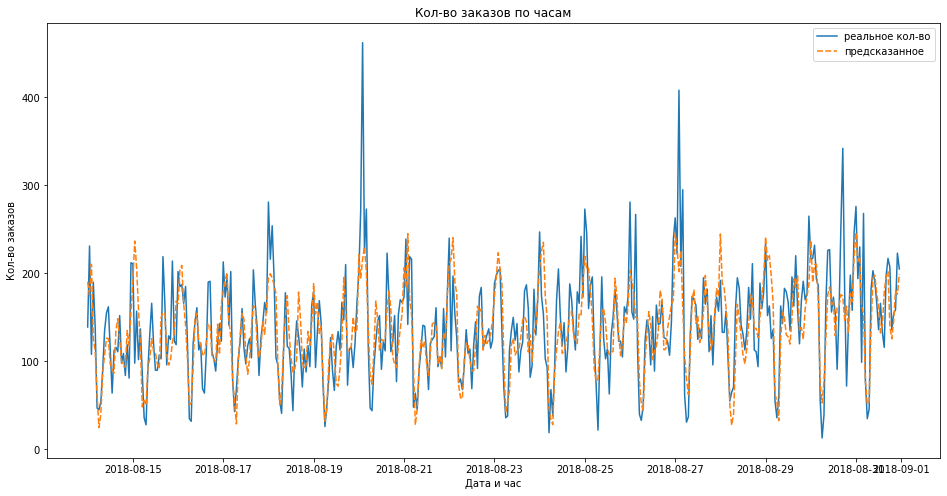

In [40]:
plt.figure(figsize=(16,8))
plt.title('Кол-во заказов по часам')
sns.lineplot(data=result)
plt.xlabel('Дата и час')
plt.ylabel('Кол-во заказов')
plt.legend(['реальное кол-во','предсказанное'])
plt.show()